**Построение ML-продукта для выявления и оптимизации платежей преподавателей сервиса Repetit.ru**

***Цель проекта:***
Разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятий будет классифицировать репетиторов на платящих и неэффективных. Оценка качества модели будет производиться с использованием метрики F1.

***План:***
1. Загрузка и предварительный анализ данных
2. Разведовочный анализ и предобработка данных
3. Формирование финального датасета
4. Валидация модели, анализ важности признаков
5. Тестирование модели

In [349]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from nltk import FreqDist, Text
from statsmodels.tsa.seasonal import seasonal_decompose
import shap

In [350]:
sns.set_style('whitegrid')
sns.set_palette('husl', n_colors=20)
plt.rcParams['lines.markersize'] = 15
plt.rcParams['font.size'] = 10 
warnings.filterwarnings('ignore')

In [351]:
random_state = 42

***1. Загрузка и предварительный анализ данных***

In [352]:
try:
    ...
except:    
    teachers = pd.read_feather('/teachers.feather')

In [353]:
def initial_analysis(df):
    print('Пример строки датасета:')
    display(df.sample(1))
    print('Общая информация о датасете:')
    print(df.info())
    print('Количество дубликатов:', df.duplicated().sum())
    print('Количество пропусков:')
    print(df.isna().sum()[df.isna().sum()!=0])

In [354]:
initial_analysis(teachers)

Пример строки датасета:


,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
1153,118886,30.0,868.421053,19.0,0.096154,3.8,16500.0,1


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 103.6 KB
None
Количество дубликатов: 0
Количество пропусков:
Series([], dtype: int64)


- открыт датасет со статистикой по репетиторам, содержащий 1656 строк и 8 столбцов с данными. Пропусков и дубликатов в таблице нет. Все данные имеют численный тип. В данном датасете присутствует целевой признак - бинарный столбец blocked

In [355]:
try:
    ...
except:    
    teachers_info = pd.read_feather('/teachers_info.feather')

In [356]:
initial_analysis(teachers_info)

Пример строки датасета:


,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
268006,272631,2022-09-16 14:46:33.297,2004-01-01 00:00:00.000,2022-09-01 00:00:00.000,0,60,0,1,2022-10-11 22:32:17.693,NaN,0,40,2,1,0


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed           30797

- открыт датасет с информацией по репетиторам, содержащий 307972 строк и 15 столбцов с данными. Пропуски есть в столбцах last_visited (72135) и is_pupils_needed (296764 - так как пропуски в этом столбце занимают 96% считаю рациональным сразу же его удалить), дубликатов в таблице нет. 11 столбцов имеют численный тип и 4 строковый (но так как это даты сразу же переведу их во временной тип). 

In [357]:
#предобработка
teachers_info.drop('is_pupils_needed', axis=1, inplace=True)
teachers_info.reg_date = pd.to_datetime(teachers_info.reg_date)
teachers_info.birth_date = pd.to_datetime(teachers_info.birth_date)
teachers_info.teaching_start_date = pd.to_datetime(teachers_info.teaching_start_date)
teachers_info.last_visited = pd.to_datetime(teachers_info.last_visited)

In [358]:
try:
    ...
except:    
    prices = pd.read_feather('/teacher_prices.feather')

In [359]:
initial_analysis(prices)

Пример строки датасета:


,date_update,teacher_id,subject_id,price,price_external,price_remote
255302,2019-08-13 13:53:33.393,173030.0,18,0,800,0


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB
None
Количество дубликатов: 860
Количество пропусков:
teacher_id    4570
dtype: int64


- открыт датасет с ценами на занятия, содержащий 432422 строки и 6 столбцов с данными. Пропуски есть в столбце teacher_id (4570), есть дубликаты в количестве 860 (которые я сразу удалю). Все столбцы имеют численный тип данных. 

In [360]:
#предобработка
prices.drop_duplicates(inplace=True)

In [361]:
try:
    ...
except:    
    orders = pd.read_feather('/orders.feather')

In [362]:
initial_analysis(orders)

Пример строки датасета:


,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,...,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
55104,2453736,2023-01-31 15:18:55.813,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,1500,60,None,125.0,Район: м. Выхино.\nМесто проведения занятий: у...,2023-02-01 17:40:46.150,...,0,0,14,2437954.0,1079666,13.0,NaN,3450,None,1


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id

- открыт датасет с заявками, содержащий 1191861 строку и 38 столбцов с данными. Пропуски есть в 17 столбцах (но в столбцах они занимают соотвественно: lesson_place - 99%, prefered_teacher_id - 99%, first_lesson_date - 86%, max_metro_distance - 99%, данные столбцы считаю целесообразным удалить сразу), есть дубликаты в количестве 900 (которые я сразу удалю). 28 столбцов имеют численный тип данных и 10 строковый (3 из них будут переведены во временной тип, так как являются датами)

In [363]:
#предобработка
orders.drop_duplicates(inplace=True)
#orders.drop(['lesson_place', 'prefered_teacher_id', 'first_lesson_date', 'max_metro_distance'],\
#     axis=1, inplace=True)
orders.order_date = pd.to_datetime(orders.order_date, errors='coerce')
orders.start_date = pd.to_datetime(orders.start_date, errors='coerce')
orders.payment_date = pd.to_datetime(orders.payment_date, errors='coerce')

In [364]:
try:
    ...
except:    
    lessons = pd.read_feather('/lessons.feather')

In [365]:
initial_analysis(lessons)

Пример строки датасета:


,id,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
1038951,3967499,1416114,2023-10-12 00:00:00.000,17:30:00,19:00:00,\nДЗ: \nДЗ от 05.10 Занятие 3\n\nПлан урока: ...,0,4500.0,NaN


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   id                1191127 non-null  int32   
 1   lesson_course_id  1191127 non-null  int32   
 2   lesson_date       1191127 non-null  category
 3   time_from         1191127 non-null  category
 4   time_to           1191127 non-null  category
 5   home_task         4969 non-null     category
 6   is_regular        1191127 non-null  int8    
 7   amount_to_pay     593376 non-null   float64 
 8   amount_paid       8143 non-null     float64 
dtypes: category(4), float64(2), int32(2), int8(1)
memory usage: 37.9 MB
None
Количество дубликатов: 0
Количество пропусков:
home_task        1186158
amount_to_pay     597751
amount_paid      1182984
dtype: int64


- открыт датасет с информацией о занятиях, содержащий 1191127 строк и 9 столбцов с данными. Пропуски есть в столбцах home_task (1186158), amount_to_pay(597751), amount_paid(1182984), дубликатов нет. 5 столбцов имеют численный тип данных и 4 категориальный. Сразу переведу дату урока во временной тип, время начала/конца урока я не могу сразу нормализовать и оставить в  качестве временной отметки из-за присутствия несоотвествующих значений, обработаю эти данные позже.

In [366]:
#предобработка
lessons.lesson_date = pd.to_datetime([x[:10] for x in lessons.lesson_date])

In [367]:
try:
    ...
except:    
    course = pd.read_feather('/lesson_course.feather')

In [368]:
initial_analysis(course)

Пример строки датасета:


,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
555457,1257698,1133019.0,289533,2573795.0,7,1000,0,60,2023-04-18 19:07:04.817,1800-01-01 00:00:00.000


Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB
None
Количество дубликатов: 0
Количество пропусков:
client_id       1
order_id     3306
dtype: int64


- открыт датасет с информацией об учениках, содержащий 893438 строк и 10 столбцов с данными. Пропуски есть в столбцах client_id (1), order_id(3306), дубликатов нет. 8 столбцов имеют численный тип данных и 2 категориальный (который я сразу переведу в формат даты)

In [369]:
#предобработка
course.date_updated = pd.to_datetime(course.date_updated)
course.suspend_till_date = pd.to_datetime(course.suspend_till_date) 

***2. Разведовательный анализ и предобработка данных***

- нужно объединить все таблицы, но в целевой таблице у нас размечены данные менее чем на 1% всех репетитров, представленных в таблице с информацией по учителям, поэтому я поочередно  проанализирую таблицы с целевой информацией, информацией об учителях, ценах, учениках и занятиях, возможно выведу какие-либо общие паттерны, сделаю выводы и на их основании попробую кластеризировать данные

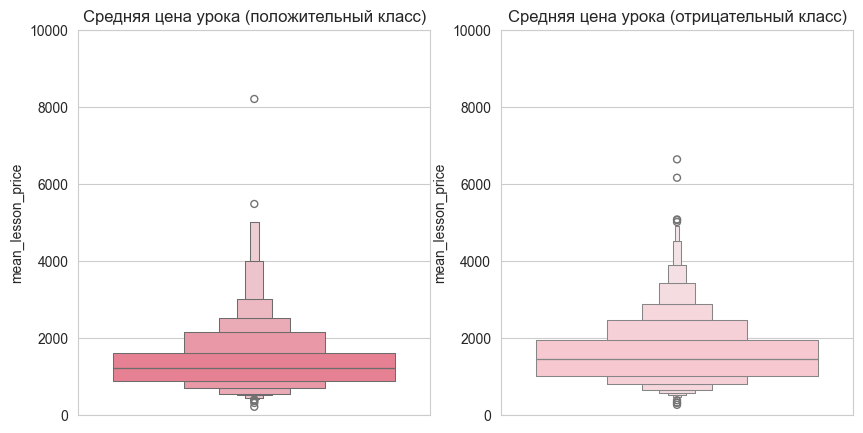

In [370]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
sns.boxenplot(teachers[teachers.blocked==1].mean_lesson_price, ax=axs[0]).set_ylim(0, 10_000)
axs[0].set_title('Средняя цена урока (положительный класс)')
sns.boxenplot(teachers[teachers.blocked==0].mean_lesson_price, ax=axs[1], color='pink')\
    .set_ylim(0, 10_000)
axs[1].set_title('Средняя цена урока (отрицательный класс)')
plt.show()

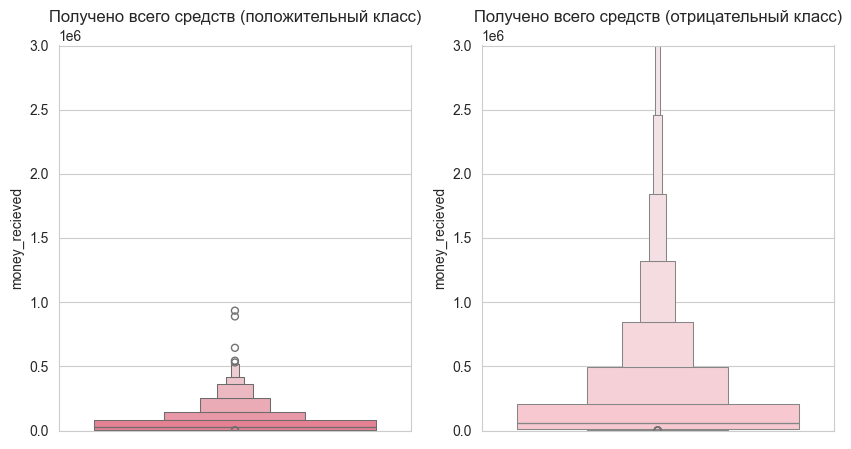

In [371]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
sns.boxenplot(teachers[teachers.blocked==1].money_recieved, ax=axs[0]).set_ylim(0, 3000_000)
axs[0].set_title('Получено всего средств (положительный класс)')
sns.boxenplot(teachers[teachers.blocked==0].money_recieved, ax=axs[1], color='pink')\
    .set_ylim(0, 3000_000)
axs[1].set_title('Получено всего средств (отрицательный класс)')
plt.show()

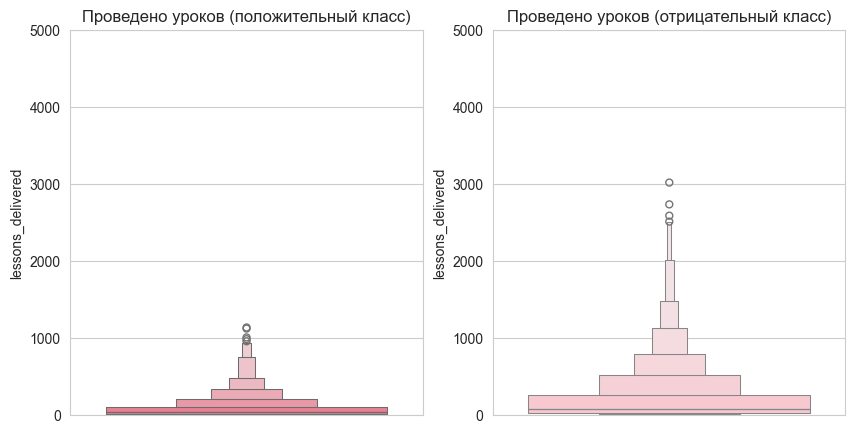

In [372]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
sns.boxenplot(teachers[teachers.blocked==1].lessons_delivered, ax=axs[0]).set_ylim(0, 5_000)
axs[0].set_title('Проведено уроков (положительный класс)')
sns.boxenplot(teachers[teachers.blocked==0].lessons_delivered, ax=axs[1], color='pink')\
    .set_ylim(0, 5_000)
axs[1].set_title('Проведено уроков (отрицательный класс)')
plt.show()

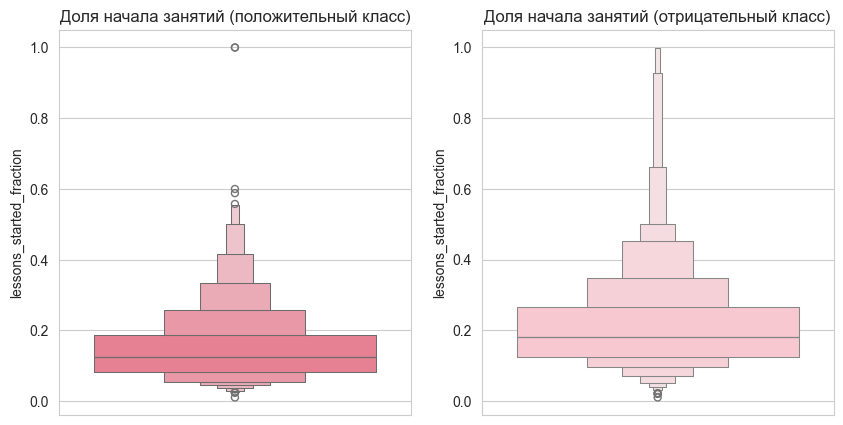

In [373]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
sns.boxenplot(teachers[teachers.blocked==1].lessons_started_fraction, ax=axs[0])
axs[0].set_title('Доля начала занятий (положительный класс)')
sns.boxenplot(teachers[teachers.blocked==0].lessons_started_fraction, ax=axs[1], color='pink')
axs[1].set_title('Доля начала занятий (отрицательный класс)')
plt.show()

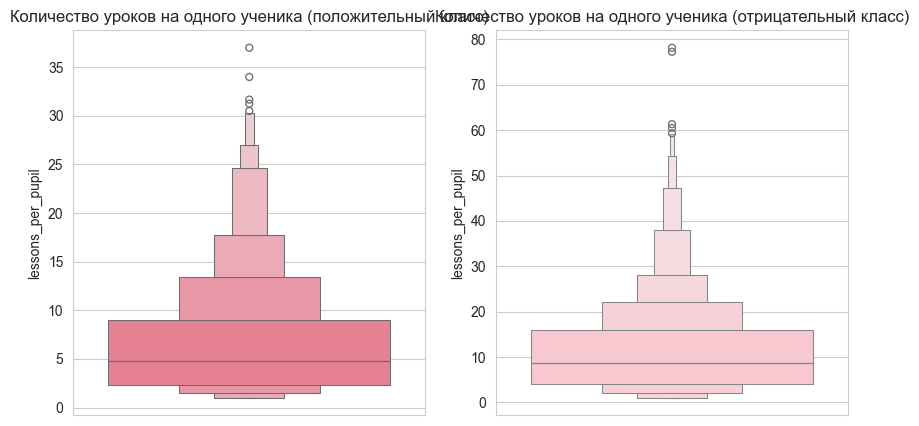

In [374]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
sns.boxenplot(teachers[teachers.blocked==1].lessons_per_pupil, ax=axs[0])
axs[0].set_title('Количество уроков на одного ученика (положительный класс)')
sns.boxenplot(teachers[teachers.blocked==0].lessons_per_pupil, ax=axs[1], color='pink')
axs[1].set_title('Количество уроков на одного ученика (отрицательный класс)')
plt.show()

- выводы по распределению признаков по отрицательному и положительному классам целевой переменной (уточню, что под положительный классом полагаю разметку "1", под отрицательным - "0"):
  - распределение средней цены урока у разных классов целевой переменной в принципе выглядит похоже, единственное - медиана у положительного класса меньше и присутствие выбросов выше, но данные показатели не критичны
  - вот уже распределения общего количества полученных средств у положительного и отрицательного классов сильно разняться:
    - у отрицательного класса общее распределение гораздо сильнее смещено вправо, то есть среднее значение сильно превышает медианное по сравнению с положительным классом, то есть прподаватели, размеченные как "честные" в общем приносят больше средств и среди них есть явные лидеры, смещающие общее распределение, ниже попробую их найти и выделить
  - распределение общего количества проведенных уроков у положительного класса логично меньше чем у отрицательного и опять же несмотря на также имеещееся смещение вправо распределения положительного класса у отрицательного оно куда более выраженное, что опять же говорит о лидерах среди репетиторов
  - распределение доли начала занятий также отличается похожим образом, несмотря на довольно низкое значение медианного показателя (но у положительного класса он все-равно ниже), среди отрицательного класса есть преподаватель практически со стопроцентным результатом, тогда как у положительного класса макимум достигает 60%
  - количество занятий на одного ученика: у отрицательного класса среднее значение выше, чем у положительного, как и общее распределение несмотря на общую тенденцию правостороннего смещения
  

In [375]:
#предобработка
teachers_info.last_visited = pd.Series(np.where(teachers_info.last_visited.isna(),\
     teachers_info.reg_date, teachers_info.last_visited))

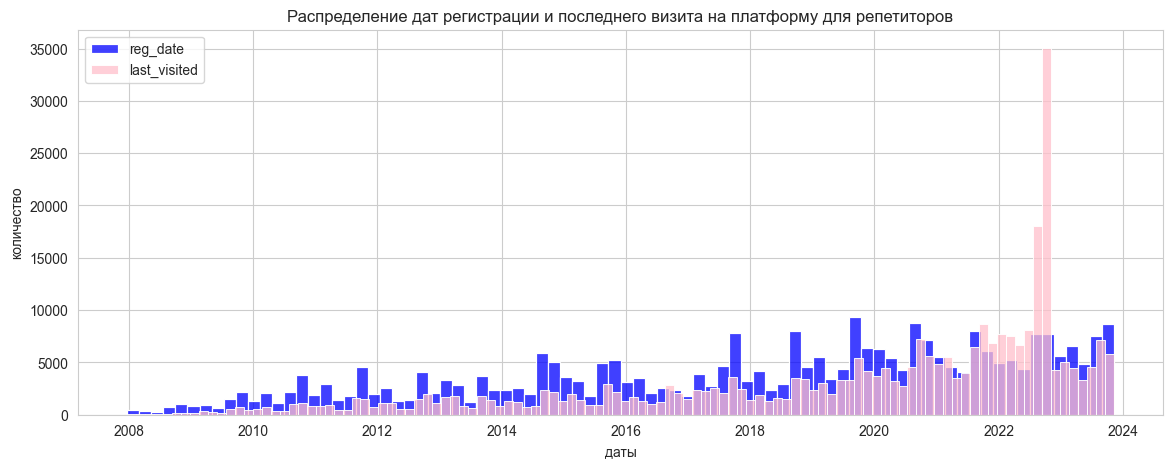

In [376]:
plt.figure(figsize= (14, 5))
ax = sns.histplot(data=teachers_info.reg_date.sort_values(), color='blue')
sns.histplot(data=teachers_info.last_visited.sort_values(), ax=ax, color='pink')\
    .set_title('Распределение дат регистрации и последнего визита на платформу для репетиторов')
ax.legend(['reg_date', 'last_visited'])
ax.set_xlabel('даты')
ax.set_ylabel('количество');

- по данному графику можно сделать следующие выводы: увеличение количества зарегистрированных репетиторов на платформе развивается равномерно с 2008 по 2024 годы (конечно имеются некоторые спады), но вот количество дат последнего визита имеют резкий взлет в 2023 году, посмотрим поближе:

In [377]:
teachers_info['lv_year'] = teachers_info.last_visited.dt.year
teachers_info['lv_month'] = teachers_info.last_visited.dt.month

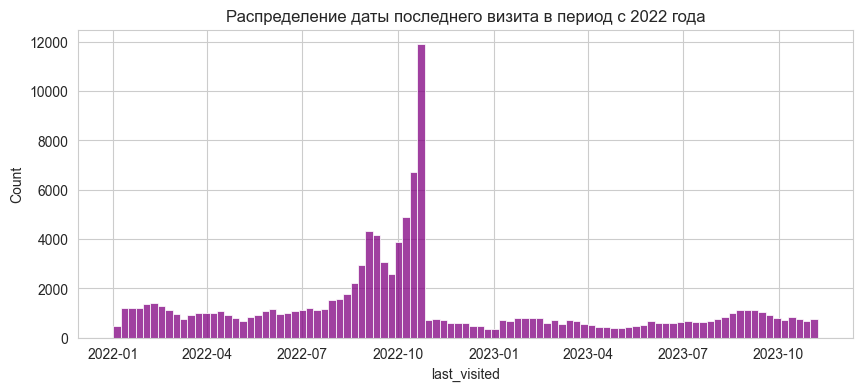

In [378]:
plt.figure(figsize=(10, 4))
plt.title('Распределение даты последнего визита в период с 2022 года')
sns.histplot(teachers_info[teachers_info.lv_year>2021].last_visited.sort_values(), color='purple');

- видно, что именно в октябре 2022 года количество зарегистрированных визитов на платформу резко увеличилось, после этого в 2023 году был такой же резкий спад
- далее посмотрю на распределения дат рождения и начала преподавательской деятельности

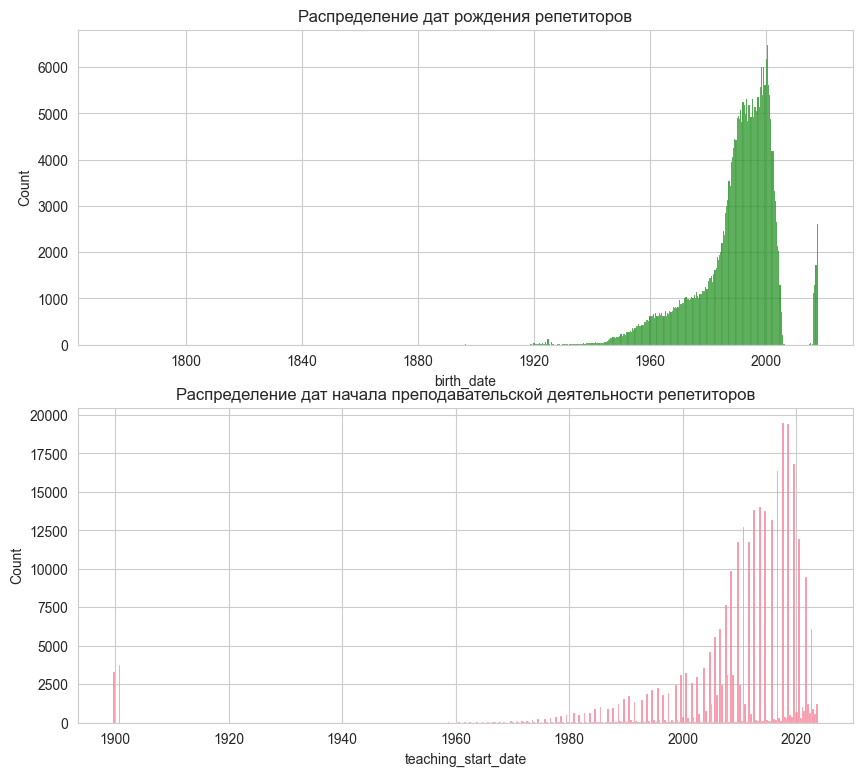

In [379]:
plt.figure(figsize=(10, 9))
plt.subplot(211)
sns.histplot(teachers_info.birth_date.sort_values(), color='green')\
    .set_title('Распределение дат рождения репетиторов')
plt.subplot(212)
sns.histplot(teachers_info.teaching_start_date.sort_values())\
    .set_title('Распределение дат начала преподавательской деятельности репетиторов');

- видим явные выбросы на обоих графиках, поставлю соотвествующие пороги (с учетом существования платформы в течение 16 лет): для даты рождения поставлю интервал с 1918 года(возраст 90 на момент 2008 года) и до 2006 (возраст 18 лет), для даты начала преподавания 1936 (плюс 18 к минимальной дате рождения) и до максимальной даты в столбце. Проверю, входят ли целевые id в выбивающиеся значения:

In [380]:
teachers_id = teachers.id.tolist()
teachers_info[(teachers_info.birth_date<'1918-01-01')|(teachers_info.birth_date>'2006-12-31')]\
    .id.isin(teachers_id).unique()

array([False])

In [381]:
teachers_info[teachers_info.teaching_start_date<'1936-01-01'].id.isin(teachers_id).unique()

array([False])

In [382]:
teachers_info = teachers_info[('1918-01-01'<teachers_info.birth_date)\
    &(teachers_info.birth_date<'2006-12-31')]
teachers_info = teachers_info[teachers_info.teaching_start_date>'1936-01-01']

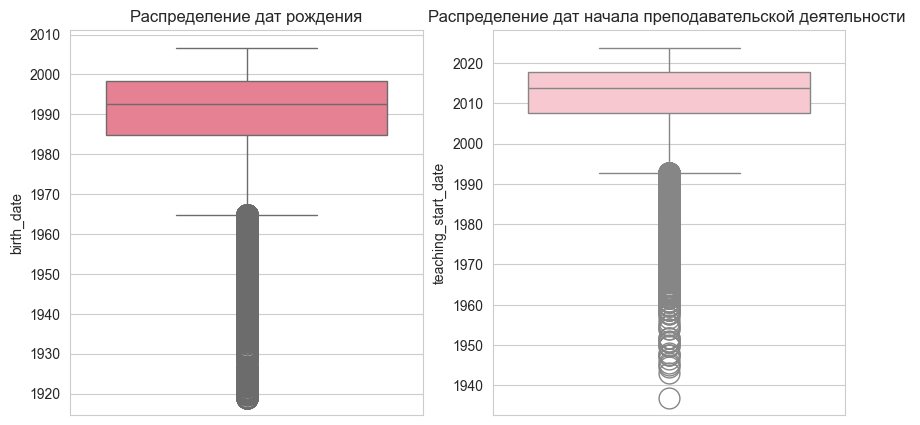

In [383]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
sns.boxplot(teachers_info.birth_date, ax=axs[0]).set_title('Распределение дат рождения')
sns.boxplot(teachers_info.teaching_start_date, ax=axs[1], color='pink')\
        .set_title('Распределение дат начала преподавательской деятельности ')

plt.show()

- целевые айди не содержат выбросов по датам рождения и начала преподования
- основная масса репетиторов родились во второй половнине 1980-х - 1990-х годах и начали преподавательскую деятельность в конце двухтысячных 2010-х годах

In [384]:
def binar_col_analys(df):
    idx=[]
    cols = {'1': [], '0': []}
    for x in df:
        idx += [x]
        cols['1'].append(int(df[x].value_counts()[df[x].value_counts().index==1].median()))
        cols['0'].append(int(df[x].value_counts()[df[x].value_counts().index==0].median()))
        df_counts = pd.DataFrame(cols, index=idx)
    
    return df_counts
bin_cols = ['is_email_confirmed', 'is_display', 'is_cell_phone_confirmed', 'orders_allowed']
binar_col_analys(teachers_info[bin_cols])

,1,0
is_email_confirmed,3007,297817
is_display,202585,98239
is_cell_phone_confirmed,1842,298982
orders_allowed,257939,42885


- по распределению бинарных признаков видно:
  - основная масса репетиторов не подтвердили электронный адрес и телефон
  - 2/3 репетиторов показаны в каталоге
  - 86% репетиторов разрешено назначать на заявки
- распределение пола репетиторов:
  - в этом столбце 4 уникальных значения (известно, что 1 - мужской пол, 2 - женский, для двух других проставлю одно значение - 0), посмотрю на распределение этого признака:

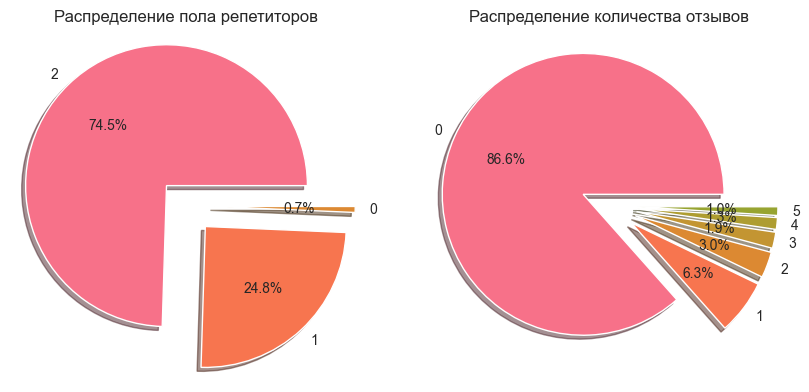

In [385]:
exp1 = [0.2, 0.2, 0.2]
exp2 = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
teachers_info.sex = np.where(teachers_info.sex.isin([0, 3]), 0, teachers_info.sex)
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
teachers_info.sex.value_counts().plot(kind='pie', autopct='%1.1f%%',\
     title='Распределение пола репетиторов', ylabel='', ax=axs[0], shadow=True,\
          explode=exp1)
teachers_info.review_num.value_counts()[:6].plot(kind='pie', autopct='%1.1f%%',\
     title='Распределение количества отзывов', ylabel='', ax=axs[1], shadow=True,\
          explode=exp2);

- видим, что 73% репетиторов - женщины
- 82% реметиторов не имеют ни одного отзыва, далее увеличение количества отзывов обратно пропорционально количеству репетиторов

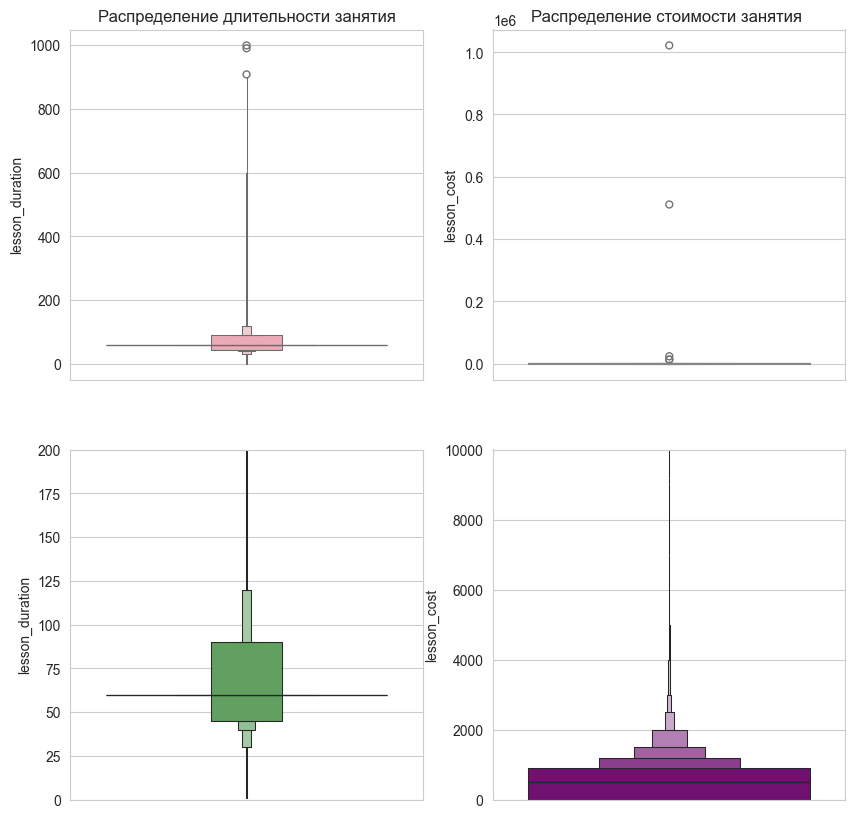

In [386]:
fig, axs = plt.subplots(figsize=(10, 10), ncols=2, nrows=2)
sns.boxenplot(teachers_info.lesson_duration, ax=axs[0,0])\
        .set_title('Распределение длительности занятия')
sns.boxenplot(teachers_info.lesson_cost, ax=axs[0,1], color='pink')\
        .set_title('Распределение стоимости занятия ')
sns.boxenplot(teachers_info.lesson_duration, ax=axs[1,0], color='green')\
        .set_ylim(0, 200)
sns.boxenplot(teachers_info.lesson_cost, ax=axs[1,1], color='purple')\
        .set_ylim(0, 10_000)

plt.show()

- видно, что в распределениях длительности и стоимости урока есть выбросы
- распределение длительности урока смещено вправо (среднее больше медианы), но не сильно (среднее - 61, медианное значение 60 минут)
- распределение стоимости урока - аналогично (среднее - 532, медианное значение 500 рублей)
- посмотрю попадают ли целевые id в выбросные значения (установлю порог длительности до 180 минут и стоимости до 10000):

In [387]:
teachers_info[teachers_info.lesson_duration>180].id.isin(teachers_id).unique()

array([False])

In [388]:
teachers_info[teachers_info.lesson_cost>10_000].id.isin(teachers_id).unique()

array([False])

- целевые значения не попадают - поэтому удалю выбросы из данной таблицы

In [389]:
teachers_info = teachers_info[teachers_info.lesson_duration<=180]
teachers_info = teachers_info[teachers_info.lesson_cost<=10_000]

- теперь попробую разбить на кластеры (при помощи KMeans) имеющиеся значения, для определения количества кластеров воспользуюсь "методом локтя", но сначала из всех дат "достану" численные признаки (год - для даты рождения/начала карьеры; год/месяц - для даты регистрации), также создам признак длительности присутствия на платформе

In [390]:
teachers_info['rg_year'] = teachers_info.reg_date.dt.year
teachers_info['rg_month'] = teachers_info.reg_date.dt.month
teachers_info['birth_year'] = teachers_info.birth_date.dt.year
teachers_info['start_year'] = teachers_info.teaching_start_date.dt.year
teachers_info['delta_on_platform'] = teachers_info.last_visited-teachers_info.reg_date
teachers_info['delta_on_platform'] = round(teachers_info['delta_on_platform']\
    .dt.total_seconds()/3600/24, 2)
teachers_info.drop(['reg_date', 'birth_date', 'teaching_start_date', 'last_visited'], axis=1,\
     inplace=True)

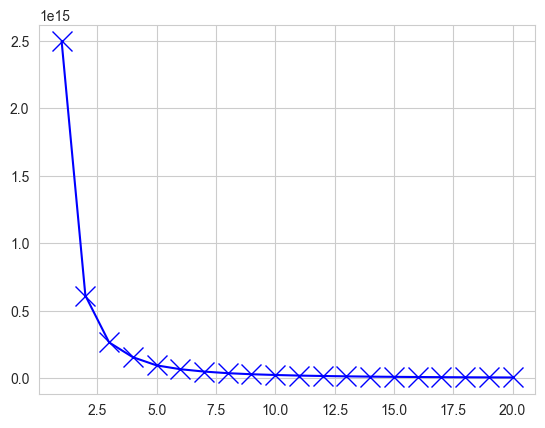

In [391]:
dis = []
K = range(1, 21)
for k in K:
    m = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    m.fit(teachers_info.drop('orders_allowed', axis=1).values)
    dis.append(m.inertia_)
plt.plot(K, dis, 'bx-');

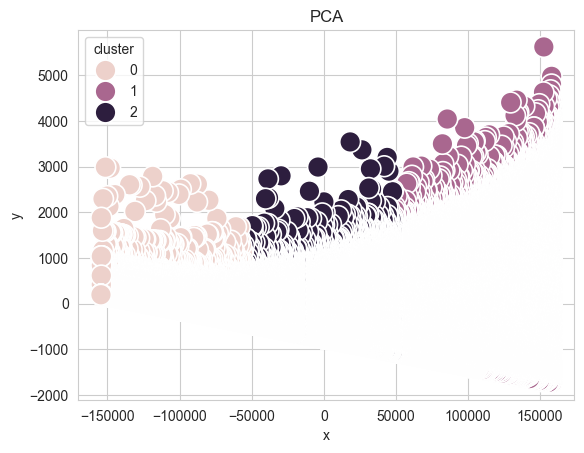

In [392]:
km_cluster = KMeans(n_clusters=3, random_state=random_state, n_init=10)\
    .fit_predict(teachers_info.drop('orders_allowed', axis=1).values)
pca3D = PCA(n_components=3, random_state=random_state)
pca_3D = pca3D.fit_transform(teachers_info.drop('orders_allowed', axis=1).values)
pca3D_df = pd.DataFrame(data = pca_3D, columns = ['x', 'y', 'z'])

pca3D_df['cluster'] = km_cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca3D_df)
plt.title("PCA")
plt.show()

-   теперь введу новый признак с номером кластера и объединю данную таблицу с целевой

In [393]:
temp_df = teachers_info.merge(pca3D_df, left_index=True, right_index=True)
teachers_info['teach_cluster'] = np.array(pca3D_df.cluster)
teachers_merged = teachers.merge(temp_df.drop('orders_allowed', axis=1), on='id')

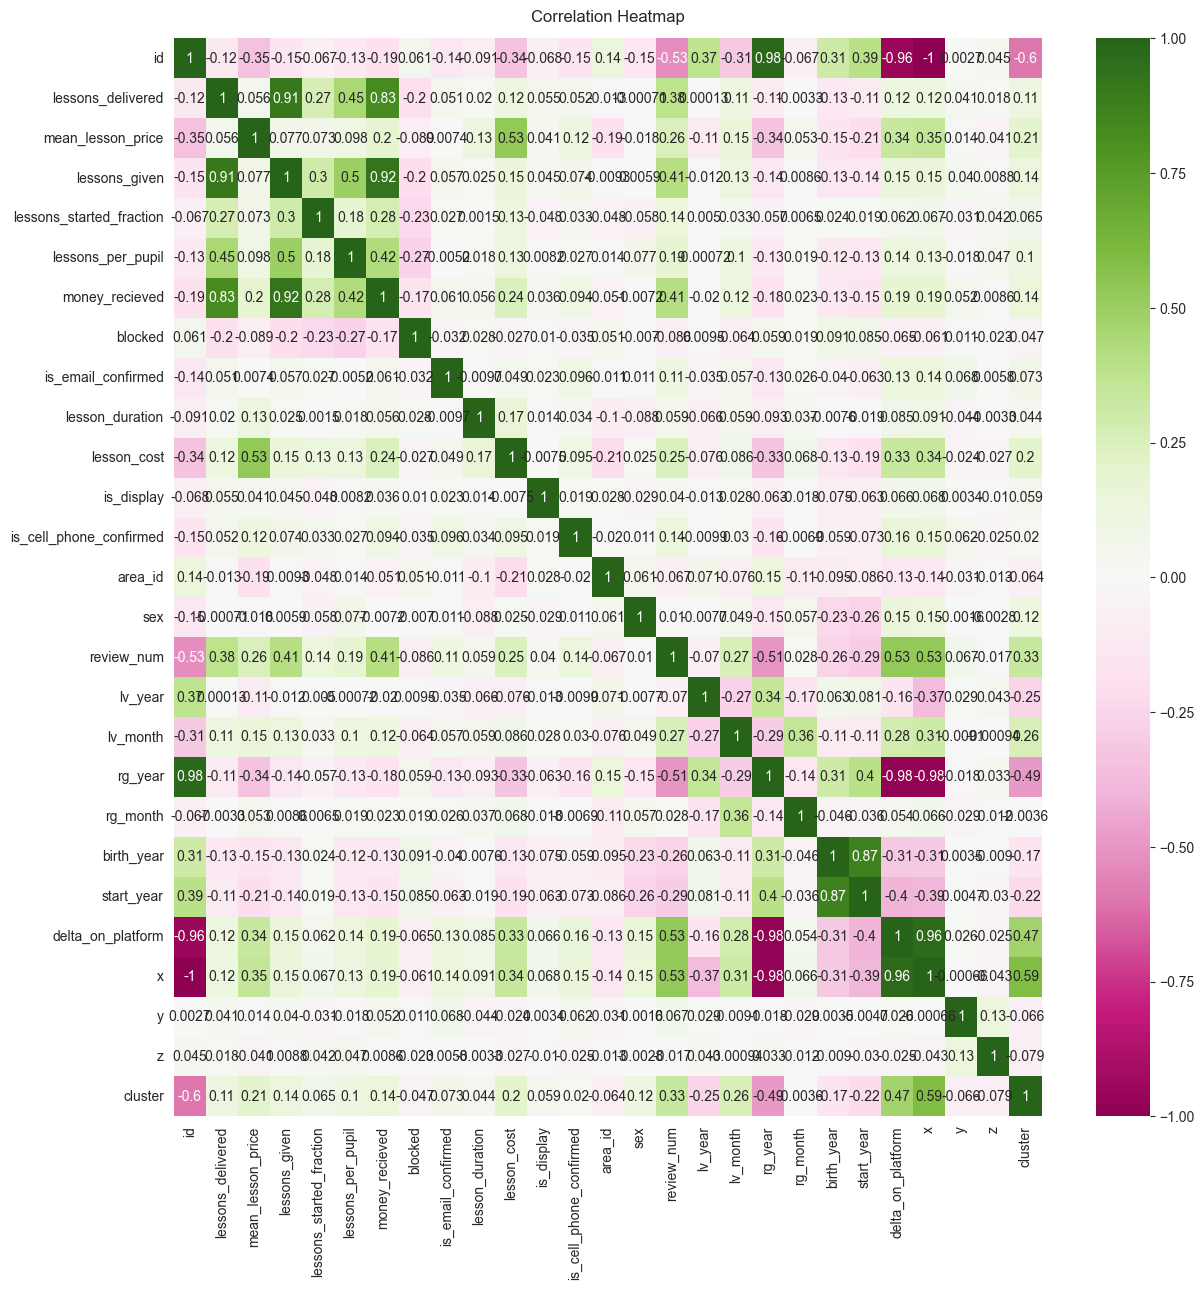

In [394]:
plt.figure(figsize=(14, 14))
heatmap = sns.heatmap(teachers_merged.corr(), vmin=-1, vmax=1, cmap='PiYG', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

- более всего таргет, кроме признаков из целевой таблицы, взаимосвязан с признаком "разрешено назначать на заявки"

- теперь сначала проведу анализ, а потом соединю с нарощенной целевой таблицей таблицу с информацией о ценах на занятия репетиторов

In [395]:
prices.date_update = pd.to_datetime(prices.date_update)
prices.date_update = prices.date_update.dt.round('H')

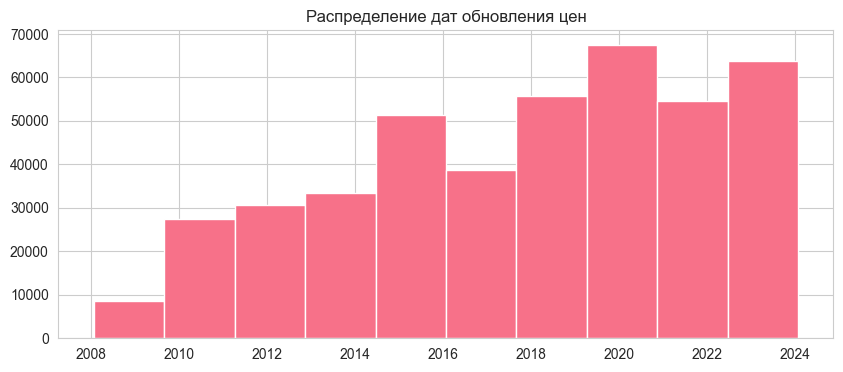

In [396]:
plt.figure(figsize=(10, 4))
prices.date_update.hist()
plt.title('Распределение дат обновления цен');

- видим планомерное увеличение количества "апдейтов" пропорционально времени (с некоторыми спадами)
- сразу достану из этого столбца численные признаки (год, месяц, день, час, день недели)

In [397]:
prices['up_year'] = prices.date_update.dt.year
prices['up_month'] = prices.date_update.dt.month
prices['up_day'] = prices.date_update.dt.day
prices['up_dweek'] = prices.date_update.dt.dayofweek
prices.drop('date_update', axis=1, inplace=True)

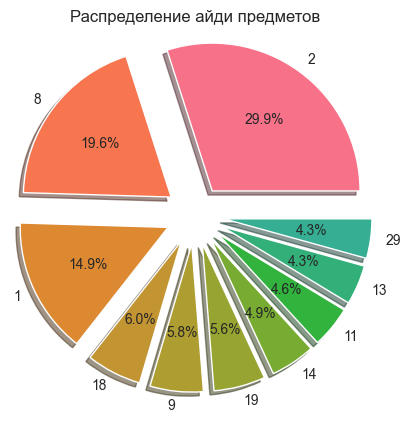

In [398]:
exp = [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
prices.subject_id.value_counts()[:10].plot(kind='pie', autopct='%1.1f%%',\
     title='Распределение айди предметов', ylabel='', shadow=True, explode=exp)
plt.show()

- видно, что бОльшим спросом пользуются предметы с айди: 2, 8, 1
- далее посмотрю на распределение цен у себя/на выезде/онлайн

Распределение цен на занятия у себя/на выезде/он-лайн


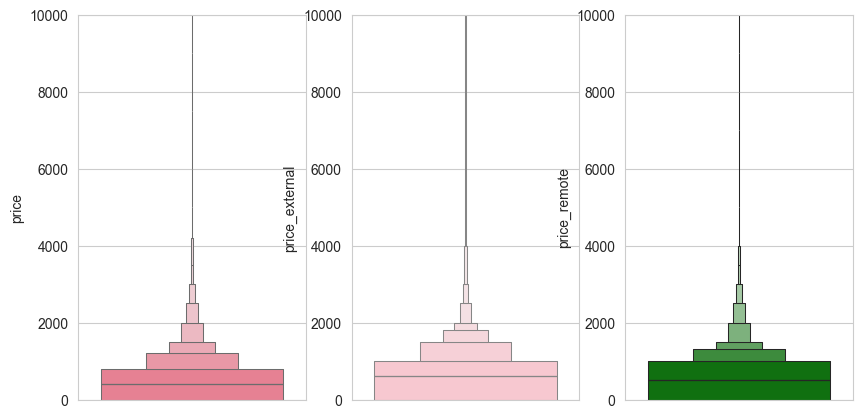

In [399]:
print('Распределение цен на занятия у себя/на выезде/он-лайн')
fig, axs = plt.subplots(figsize=(10, 5), ncols=3)
sns.boxenplot(prices.price, ax=axs[0]).set_ylim(0, 10_000)
sns.boxenplot(prices.price_external, ax=axs[1], color='pink').set_ylim(0, 10_000)
sns.boxenplot(prices.price_remote, ax=axs[2], color='green').set_ylim(0, 10_000)

plt.show()

- видим, что у всех данных признаков есть выбросы (поэтому я ограничила вертикальную ось порогом в 10_000)
- что все признаки распределены в принципе аналогично: распределение смещено вправо (среднее превышает медианное значение: для цены у себя - среднее - 552/медианное - 400; для занятия на выезде - среднее - 746/медианное - 600; для онлайн-занятия - среднее - 673, медианное - 500)
- посмотрим есть ли целевые индексы в выбросных показателях цен:

In [400]:
prices[prices.price>10_000].teacher_id.isin(teachers_id).unique()

array([False])

In [401]:
prices[prices.price_external>10_000].teacher_id.isin(teachers_id).unique()

array([False])

In [402]:
prices[prices.price_remote>10_000].teacher_id.isin(teachers_id).unique()

array([False])

- выбросов по данным признакам у целевых айди нет
- теперь аналогичным образом разобью данные на кластеры (сначала удалю пропущенные значения, это придется сделать так как пропуски только в столбце с айди учителя)

In [403]:
prices.dropna(inplace=True)

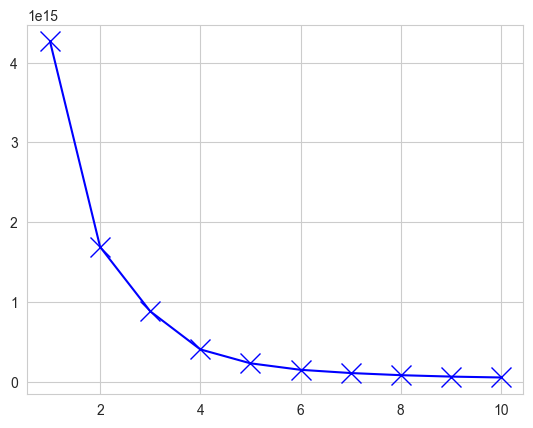

In [404]:
dis = []
K = range(1, 11)
for k in K:
    m = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    m.fit(prices.values)
    dis.append(m.inertia_)
plt.plot(K, dis, 'bx-');

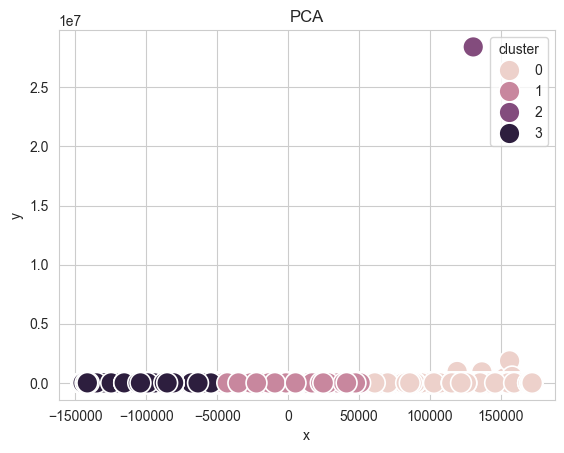

In [405]:
km_cluster = KMeans(n_clusters=4, random_state=random_state, n_init=10).fit_predict(prices.values)
pca4D = PCA(n_components=4, random_state=random_state)
pca_4D = pca4D.fit_transform(prices.values)
pca4D_df = pd.DataFrame(data = pca_4D, columns = ['x', 'y', 'z', 'a'])

pca4D_df['cluster'] = km_cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca4D_df)
plt.title("PCA")
plt.show()

In [406]:
prices['price_cluster'] = np.array(pca4D_df.cluster)

In [407]:
grouped_prices = prices.\
     groupby('teacher_id', as_index=False).agg(price_cluster = ('price_cluster', 'first'),
     subject_id = ('subject_id', 'first'), price = ('price', 'sum'),\
        price_external = ('price_external', 'sum'), price_remote = ('price_remote', 'sum'),
            up_year = ('up_year', 'first'), up_month = ('up_month', 'first'),
                 up_day = ('up_day', 'first'), up_dweek = ('up_dweek', 'first'))

In [408]:
merged_df =  teachers_merged.merge(grouped_prices, left_on='id', right_on='teacher_id')

- теперь проанализирую и объединю таблицы с данными по занятиям и ученикам:
  - таблица заняти:
    - сразу выведу дополнительный признак - длительность занятия в минутах

In [409]:
lessons['lesson_time'] = (pd.to_datetime([x[:10] for x in lessons.time_to]) -\
     pd.to_datetime([x[:10] for x in lessons.time_from])).total_seconds()/60

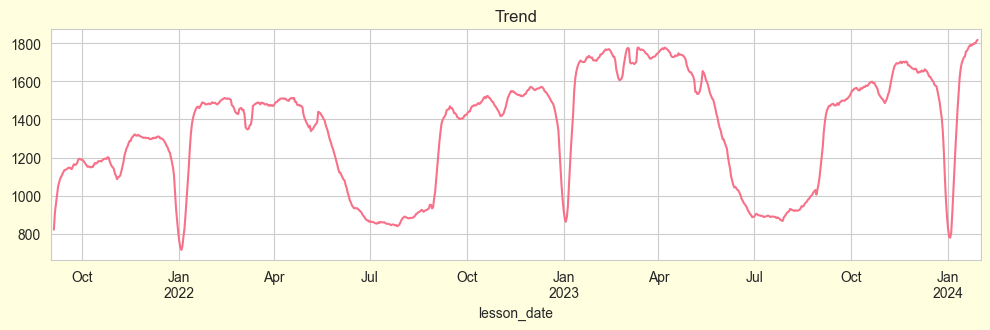

In [410]:
for_decomp = lessons[['id', 'lesson_date']]
for_decomp.index = for_decomp.lesson_date
for_decomp.drop('lesson_date', axis=1, inplace=True)
for_decomp.sort_index(inplace=True)
resampled = for_decomp.resample('D').agg('count')
plt.figure(figsize=(12,3), facecolor='lightyellow')
seasonal_decompose(resampled).trend.plot(ax=plt.gca())
plt.title('Trend');

In [411]:
binar_col_analys(lessons[['is_regular']])

,1,0
is_regular,201996,989131


In [412]:
FreqDist(Text(lessons.home_task[lessons.home_task.isna()==False])).most_common(10)

[('дано', 107),
 ('Дано', 98),
 (' ', 45),
 ('\n', 35),
 ('не задано', 29),
 ('1250', 17),
 ('Задано', 11),
 ('Да', 11),
 ('Щ', 10),
 ('занятие отменено', 10)]

Распределение стоимости занятий и оплаченных занятий


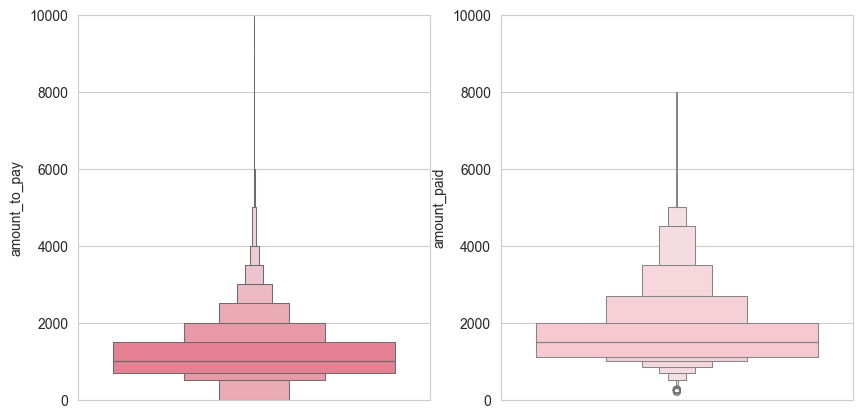

In [413]:
print('Распределение стоимости занятий и оплаченных занятий')
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
sns.boxenplot(lessons.amount_to_pay, ax=axs[0]).set_ylim(0, 10_000)
sns.boxenplot(lessons.amount_paid, ax=axs[1], color='pink').set_ylim(0, 10_000)
plt.show()

- по графику тренда дат занятий видно, что он явно присутствует - количество занятий распределяется по датам волнообразно (пики приходятся на октябрь-апрель, начало учебного года/подготовка к экзаменам, спады на январь/летние месяцы). В связи с этим извлеку из даты месяц в качестве численного признака
- по бинарному столбцу "is_regular" видно, что только около 20% занятий автоматически возобновляются
- по наиболее популярным фразам в текстовом столбце с пометками о домашнем задании видно, что никакой релевантной информации он не несет и к тому же содержит более 99% пропусков не буду использовать его в дальнейшем
- по распределению столбца со стоимость занятия видно, что распределение неравномерное, смещено вправо (среднее - 1184, медиана - 1000), также в столбце присуствуют выбросы
- по распределению столбца с уже оплаченными занятиями ситуация аналогична: среднее - 1817, медиана - 1500, и также есть выбросы
- интересно, что агрегатные показатели стоимостных признаков в данном столбце примерно на 40-50% превышают аналогичные показатели в таблице с ценами на занятия и в таблице с информацией по преподавателям!
- далее проведу анализ таблицы с информацией по ученикам:

In [414]:
lessons['lesson_month'] = lessons.lesson_date.dt.month

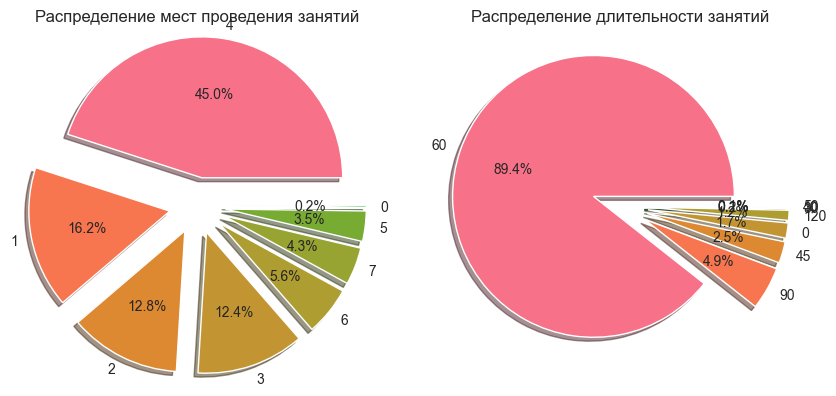

In [415]:
exp=[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
course.lesson_place.value_counts().plot(kind='pie', autopct='%1.1f%%',\
     title='Распределение мест проведения занятий', ylabel='', ax=axs[0],\
          shadow=True, explode=exp)
course.lesson_duration.value_counts()[:8].plot(kind='pie', autopct='%1.1f%%',\
     title='Распределение длительности занятий', ylabel='', ax=axs[1],\
          shadow=True, explode=exp);

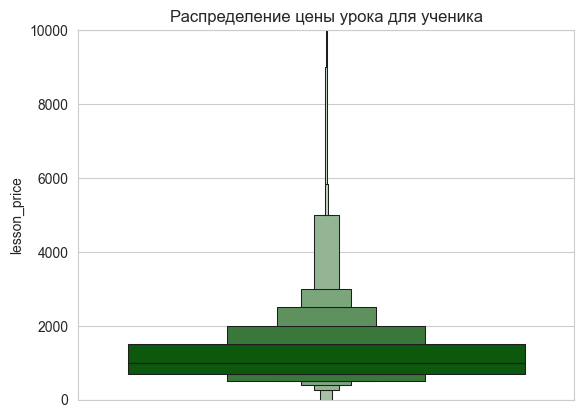

In [416]:
plt.title('Распределение цены урока для ученика')
sns.boxenplot(course.lesson_price, color='darkgreen').set_ylim(0, 10_000);

In [417]:
binar_col_analys(course[['is_active']])

,1,0
is_active,198566,694872


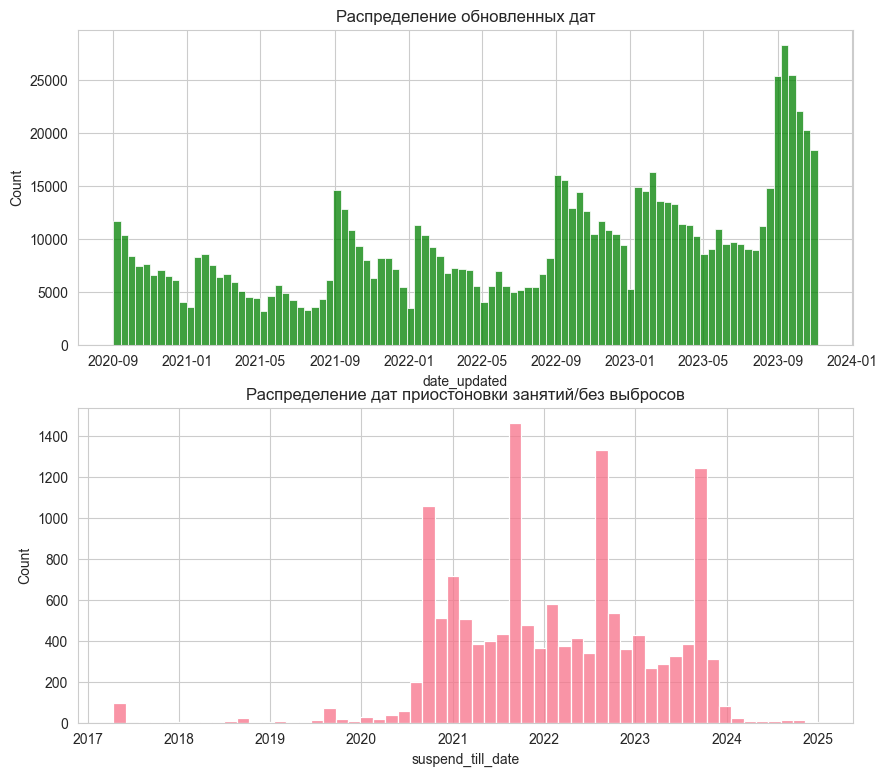

In [418]:
plt.figure(figsize=(10, 9))
plt.subplot(211)
sns.histplot(course.date_updated.sort_values(), color='green')\
    .set_title('Распределение обновленных дат')
plt.subplot(212)
sns.histplot(course.suspend_till_date[(course.suspend_till_date>'1801-01-01 00:00:00.000')\
    &(course.suspend_till_date<'2025-01-01 00:00:00.000')].sort_values())\
    .set_title('Распределение дат приостоновки занятий/без выбросов');

- по распределению мест проведения занятий видно, что большинство(45%) занятий находятся в месте под меткой 4
- 89% занятий имеют длительность в 1 час
- цена урока для ученика распределена со смещением вправо (среднее - 1284, медиана - 1000), также в столбце присутствуют выбросы
- только порядка 30% занятий имеют активный статус
- обновленные даты занятий для учеников имеют такой же тренд как и даты в таблице с занятиями, поэтому не буду оставлять этот коллинеарный признак в датасете
- а вот столбец с информацией о приостановлении занятий до определенной даты имеет некоторые особенности: большинство дат в нем носит явно "вымышленный" характер как то 19 или 22 век, но так как информация в нем может носить полезный характер, из реально возможных дат я достану численные признаки с месяцем и годом, получившиеся пропуски заполню нолями и таким образом создам два новых признака с месяцем и годом приостановки занятия
- далее я сгруппирую таблицу с занятиями по айди ученика и объединю ее с таблицей с информацией об учениках

In [419]:
course['stop_month'] = np.where(course.suspend_till_date\
    .isin(course.suspend_till_date[(course.suspend_till_date>'2015-01-01 00:00:00.000')\
        &(course.suspend_till_date<'2025-01-01 00:00:00.000')]), course.suspend_till_date.dt.month, 0)
course['stop_year'] = np.where(course.suspend_till_date\
    .isin(course.suspend_till_date[(course.suspend_till_date>'2015-01-01 00:00:00.000')\
        &(course.suspend_till_date<'2025-01-01 00:00:00.000')]), course.suspend_till_date.dt.year, 0)
course.drop(['date_updated', 'suspend_till_date'], axis=1, inplace=True)

In [420]:
grouped_lessons = lessons.groupby('lesson_course_id', as_index=False)\
    .agg(sum_regular = ('is_regular', 'sum'), amount_to_pay_sum = ('amount_to_pay', 'sum'),\
        amount_to_pay_mean = ('amount_to_pay', 'mean'),\
        amount_to_pay_std = ('amount_to_pay','std'),\
        amount_to_pay_median = ('amount_to_pay', 'median'),
        amount_paid_sum = ('amount_paid', 'sum'), amount_paid_std = ('amount_paid', 'std'),
        amount_paid_median = ('amount_paid', 'median'),\
        amount_paid_mean = ('amount_paid', 'mean'),\
        lesson_time = ('lesson_time', 'median'),\
            lesson_month = ('lesson_month', 'first'))

In [421]:
course[course.order_id.isna()].teacher_id.isin(teachers_id).unique()

array([False,  True])

In [422]:
merged_lessons = grouped_lessons.merge(course, left_on='lesson_course_id', right_on='id')

- несмотря на то, что в служебном столбце с айди заявки есть пропуски не буду их удалять, так как в эти строки входят целевые индексы учителей, просто закрою их заглушкой 0
- теперь также разделю объединенный датасет с учениками/занятиями на кластеры
- затем сгруппирую ее уже по айди учителя и опять наращу целевую таблицу

In [423]:
merged_lessons = merged_lessons.fillna(0)

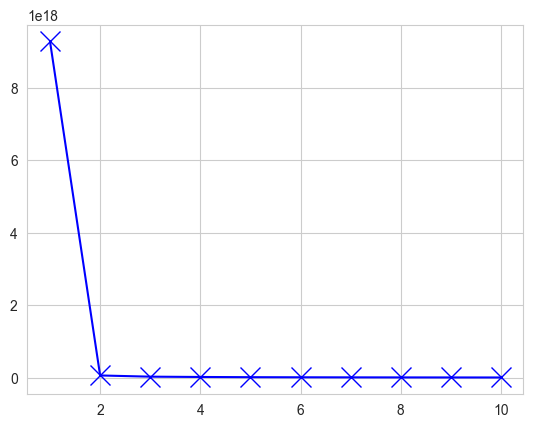

In [424]:
dis = []
K = range(1, 11)
for k in K:
    m = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    m.fit(merged_lessons.values)
    dis.append(m.inertia_)
plt.plot(K, dis, 'bx-');

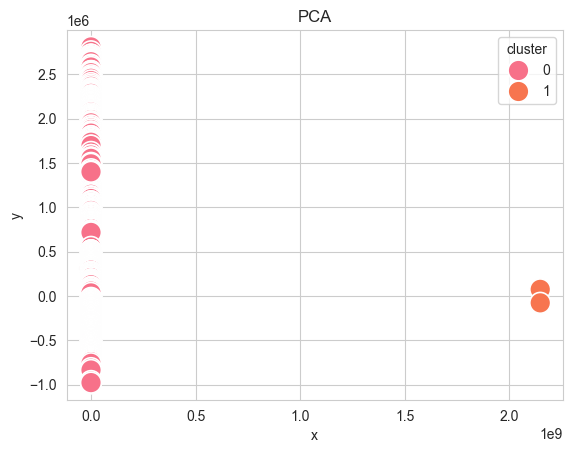

In [425]:
km_cluster = KMeans(n_clusters=2, random_state=random_state, n_init=10).fit_predict(merged_lessons.values)
pca2D = PCA(n_components=2, random_state=random_state)
pca_2D = pca2D.fit_transform(merged_lessons.values)
pca2D_df = pd.DataFrame(data = pca_2D, columns = ['x', 'y'])

pca2D_df['cluster'] = km_cluster

sns.scatterplot(x='x', y='y', hue='cluster', data=pca2D_df)
plt.title("PCA")
plt.show()

In [426]:
merged_lessons['lesson_cluster'] = np.array(pca2D_df.cluster)

In [427]:
temp_df = merged_lessons.merge(pca2D_df, left_index=True, right_index=True)

In [428]:
grouped_merg_lessons = temp_df.groupby('teacher_id', as_index=False)\
    .agg(
        sum_regular = ('sum_regular', 'sum'),\
        amount_to_pay_sum = ('amount_to_pay_sum', 'median'),\
        amount_to_pay_std = ('amount_to_pay_std', 'median'),\
        amount_to_pay_median = ('amount_to_pay_median', 'median'),\
        amount_to_pay_mean = ('amount_to_pay_mean', 'median'),\
        amount_paid_sum = ('amount_paid_sum', 'median'),\
        amount_paid_std = ('amount_paid_std', 'median'),\
        amount_paid_median = ('amount_paid_median', 'median'),\
        amount_paid_mean = ('amount_paid_mean', 'median'),\
        lesson_time = ('lesson_time', 'first'),\
        lesson_month = ('lesson_month', 'first'), lesson_place = ('lesson_place', 'first'),\
        lesson_price = ('lesson_price', 'median'), sum_active = ('is_active', 'sum'),\
        lesson_duration = ('lesson_duration', 'first'), stop_month = ('stop_month', 'first'),\
        stop_year = ('stop_year', 'first'), order_id = ('order_id', 'first'),\
        client_id = ('client_id', 'first'),\
        lesson_cluster = ('lesson_cluster', 'first'), x = ('x', 'first'), y = ('y', 'first'))

In [429]:
merged_df_ = merged_df.merge(grouped_merg_lessons, left_on='id', right_on='teacher_id')

- датасет с заявками:
  - так как проводила подробный разбор данного датасета на прошлой мастерской сюда его выносить не буду, просто перенесу сюда необходимую информацию:
- необходимо удалить строки, id которых равно 3211265, 3342337, 3605505, так как оно задублировано в других численных признаках, возможно было бы сохранить эти строки, но в них кроме этой информации, только "выбросы" и пропуски
- столбец start_date практически дублирует столбец с датой оформления заявки, будет удален
- пол репетитора: по данным заказчика значение 1 - мужской, 2-женский, 0 и 3 -"пол неизвестен", изменим этот столбец установив единое значение 0 для неизвестных значений
- данные о минимальном/максимальном возрасте учителя содержат выбросы, возрастной диапазон ограничу интервалом от 16 до 90 лет, другие значения заполню вторым по популярности ответом клиента
- относительно столбца с комментариями, в нем в основном служебная информация от операторов колл-центра. Единственным важным элементном в этом столбце я нашла отсылки на оригинальный номер заявки, проверю, возможно он отсутствует в original_order_id, и тогда можно будет восстановить пропущенные значения

In [430]:
orders[(orders.id == 3211265)|(orders.id==3342337)|(orders.id==3605505)]

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,...,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
105390,3211265,NaT,3211265.0,None,3211265,3211265,None,3211265.0,None,NaT,...,1,1,3211265,3211265.0,3211265,3211265.0,3211265.0,"8,344264636103745E-308",NaT,1
109392,3342337,NaT,3342337.0,None,3342337,3342337,None,3342337.0,None,NaT,...,1,1,3342337,3342337.0,3342337,3342337.0,3342337.0,"8,344239172283769E-308",NaT,1
437216,3605505,NaT,3605505.0,None,3605505,3605505,None,3605505.0,None,NaT,...,1,1,3605505,3605505.0,3605505,3605505.0,3605505.0,"4,450342944189884E-308",NaT,1


In [431]:
orders = orders[(orders.id != 3211265)&(orders.id!=3342337)&(orders.id!=3605505)]
orders.drop('start_date', axis=1, inplace=True)
orders.teacher_sex = [1 if x==1 else 2 if x==2 else 0 for x in orders.teacher_sex]
orders.loc[(orders.teacher_age_from<16)|(orders.teacher_age_from>90), 'teacher_age_from']\
     = orders.teacher_age_from.value_counts().index[1]
orders.loc[(orders.teacher_age_to<16)|(orders.teacher_age_to>90), 'teacher_age_to']\
     = orders.teacher_age_to.value_counts().index[1]

In [432]:
orders.comments = orders.comments.fillna('No')
orders['dubl_origin_id'] = pd.Series([''.join(re.findall('\d{7}', x)) for x in orders.comments])
orders.dubl_origin_id = orders.dubl_origin_id.astype(str).replace('', None)

In [433]:
orders.original_order_id.isna().sum()

608721

In [434]:
pd.Series(np.where(orders.original_order_id.isna(), orders.dubl_origin_id, orders.original_order_id))\
    .isna().sum()

541456

- таким образом удается восстановить порядка 60 тыс пропущенных значений в столбце original_order_id
- столбец статус-айди обозначает статус оплаты заявки, из него я создам дополнительный признак order_paid, в котором к положительному классу (заявка оплачена) отнесу (по информации от заказчика) значения 5, 6, 13, 15; а к отрицательному все остальные значения
- так как данные будут группироваться по колонке original_order_id, если в ней пропущенное значение значит заявка без дубля и сама является оригиналом,  сначала все эти пропуски заполню данными из столбца id заявки
- так же создам новый столбец ***client_num_orders***, характеризующий количество заявок от одного клиента 

In [435]:
orders.original_order_id = np.where(orders.original_order_id.isna(), orders.dubl_origin_id,
 orders.original_order_id)
orders['order_paid'] = np.where(orders.status_id.isin([5, 6, 13, 15]), 1, 0)

In [436]:
orders['original_order_id'] = np.where(orders.original_order_id.isna(), orders.id,\
     orders.original_order_id)
group = orders.groupby('original_order_id', as_index=False)
orders['order_paid'] = group.order_paid.transform(lambda x: 1 if x.sum()>0 else 0)
orders.drop('id', axis=1, inplace=True)
orders = orders.rename(columns={'original_order_id': 'order_id'})

In [437]:
client_group = orders.groupby('client_id')
num_double = []
for k, v in client_group:
    for n in range(1, len(v)+1):
        num_double.append(n)
orders['client_num_orders'] = num_double
orders = orders[orders.client_num_orders<=10]

- далее извлеку числовые признаки из столбцов временного типа 
- приведу строковые столбцы с информацией об оплате к численному типу
- сгруппирую таблицу с заявками

In [438]:
orders['order_year'] = orders.order_date.dt.year
orders['order_month'] = orders.order_date.dt.month
orders['payment_year'] = orders.payment_date.dt.year
orders['payment_month'] = orders.payment_date.dt.month

In [439]:
orders['amount_to_pay'] = [float(re.sub(',', '.', x)) for x in orders.amount_to_pay]
orders.estimated_fee = orders.estimated_fee.fillna('0')
orders.estimated_fee = [re.sub(',', '.', x) for x in orders.estimated_fee]
orders.estimated_fee = orders.estimated_fee.astype('float32')
orders.order_id = orders.order_id.astype(int)

In [440]:
grouped_orders = orders.groupby('working_teacher_id', as_index=False)\
    .agg(order_date = ('order_date', 'first'), subject_id = ('subject_id', 'last'),\
        lesson_price_mean = ('lesson_price', 'mean'),\
        order_id_count = ('order_id', 'count'),\
        lesson_price_median = ('lesson_price', 'median'),\
        lesson_price_std = ('lesson_price', 'std'),\
        home_metro_id_count = ('home_metro_id', 'count'),\
        lesson_duration = ('lesson_duration', 'mean'),\
        home_metro_id = ('home_metro_id', 'last'),\
        status_id = ('status_id', 'first'), status_id_count = ('status_id', 'count'),\
        amount_to_pay_std = ('amount_to_pay','std'),\
        amount_to_pay_mean = ('amount_to_pay', 'mean'),\
        amount_to_pay_median = ('amount_to_pay', 'median'),\
        planned_lesson_number = ('planned_lesson_number', 'first'),\
        planned_lesson_number_sum = ('planned_lesson_number', 'sum'),\
        creator_id = ('creator_id', 'first'),\
        pupil_category_new_id = ('pupil_category_new_id', 'first'),\
        pupil_category_new_id_count = ('pupil_category_new_id', 'count'),\
        lessons_per_week = ('lessons_per_week', 'first'),\
        lessons_per_week_sum = ('lessons_per_week', 'sum'),\
        minimal_price_std = ('minimal_price', 'std'),\
        minimal_price_mean = ('minimal_price', 'mean'),\
        teacher_sex = ('teacher_sex','first'),\
        minimal_price_median = ('minimal_price','median'),\
        teacher_experience_from = ('teacher_experience_from', 'first'),\
        teacher_experience_to = ('teacher_experience_to', 'first'),\
        chosen_teachers_only = ('chosen_teachers_only', 'first'),
        no_teachers_available = ('no_teachers_available', 'first'),\
        source_id = ('source_id', 'first'), source_id_count = ('source_id', 'count'),\
        client_id = ('client_id','first'), client_id_count = ('client_id','count'),\
        additional_status_id = ('additional_status_id', 'first'),\
        max_metro_distance = ('max_metro_distance', 'mean'),\
        estimated_fee_mean = ('estimated_fee', 'mean'),\
        estimated_fee_std = ('estimated_fee','std'),\
        estimated_fee_median = ('estimated_fee', 'median'),\
        payment_date = ('payment_date','first'),\
        is_display_to_teachers = ('is_display_to_teachers', 'first'),\
        order_paid = ('order_paid', 'first'), order_paid_sum = ('order_paid', 'sum'),\
        client_num_orders = ('client_num_orders','first'),\
        client_num_orders_sum = ('client_num_orders','sum'),\
        order_year = ('order_year', 'first'),  order_month = ('order_month', 'first'),\
        payment_year = ('payment_year', 'first'),\
        payment_month = ('payment_month', 'first'))
grouped_orders =  grouped_orders.fillna(0)

***3. Формирование финального датасета:***

- сначала присоединю таблицу с заявками к уже нарощенной таблице (уберу при этом дублирующие колонки и переименую некоторые столбцы)
- и далее займусь генерацией искуственных признаков

In [441]:
df = merged_df_.merge(grouped_orders, left_on='teacher_id_x', right_on='working_teacher_id')
df.drop(['teacher_id_y', 'lesson_duration_y', 'subject_id_y', 'amount_to_pay_std_y',
     'amount_to_pay_mean_y',\
     'amount_to_pay_median_y', 'client_id_y'], axis = 1, inplace=True)
df = df.rename(columns={'teacher_id_x': 'teacher_id',\
     'subject_id_x': 'subject_id',\
      'amount_to_pay_std_x': 'amount_to_pay_std',\
      'amount_to_pay_median_x': 'amount_to_pay_median',\
      'amount_to_pay_mean_x': 'amount_to_pay_mean', 'client_id_x': 'client_id',\
      })

In [442]:
df['op_ap_med'] = np.where((df.order_paid==1)&(df.amount_paid_median==0), 1, 0)
df['op_ap_mean'] = np.where((df.order_paid==1)&(df.amount_paid_mean==0), 1, 0)
df['op_ap_std'] = np.where((df.order_paid==1)&(df.amount_paid_std==0), 1, 0)
df['no_ap_med'] = np.where((df.client_num_orders>=6)&(df.amount_paid_median==0), 1, 0)
df['nos_ap_med'] = np.where((df.client_num_orders_sum.mean()>140)\
    &(df.amount_paid_median==0), 1, 0)
df['nos_ap_mean'] = np.where((df.client_num_orders_sum.mean()>140)\
    &(df.amount_paid_mean==0), 1, 0)
df['mr_ap_med'] = np.where((df.money_recieved >15_000)&(df.amount_paid_median==0), 1, 0)
df['ld_ap_med'] = np.where((df.lessons_delivered>100)&(df.amount_paid_median==0), 1, 0)
df['lg_ap_med'] = np.where((df.lessons_given>150)&(df.amount_paid_median==0), 1, 0)
df['ls_ap_med'] = np.where((df.lessons_started_fraction>=0.4)&(df.amount_paid_median==0), 1, 0)
df['lpp_ap_med'] = np.where((df.lessons_per_pupil>=6)&(df.amount_paid_median==0), 1, 0)
df['ai_mlp'] = np.where((df.area_id==1)&(df.mean_lesson_price<=700), 1, 0)
df['ai_not_msk'] = np.where((df.area_id!=1)&(df.mean_lesson_price<=300), 1, 0)
df['rn_ap_med'] = np.where((df.review_num>=11)&(df.amount_paid_median==0), 1, 0)
df['ap_sum_ap'] = np.where((df.amount_to_pay_sum>=5500)&(df.amount_paid_median==0), 1, 0)
df['ap_std_ap'] = np.where((df.amount_to_pay_std>=10)&(df.amount_paid_median==0), 1, 0)
df['oic_ap'] = np.where((df.order_id_count>=57)&(df.amount_paid_median==0), 1, 0)

Я создала следующие признаки:
  - заявка оплачена, медианная сумма/средняя/отклонение суммы оплаты равно нулю
  - количество заявок больше/равно 6, медианная сумма оплаты равно нулю
  - среднее общей суммы заявок больше 140, медианная/средняя сумма оплаты равно нулю
  - получено более 15 тыс.руб., медианная сумма оплаты равно нулю
  - поставлено более 100 уроков, медианная сумма оплаты равно нулю
  - проведено более 150 уроков, медианная сумма оплаты равно нулю
  - доля начала занятий равна или более 0.4, медианная сумма оплаты равно нулю
  - более 6 уроков на одного ученика, медианная сумма оплаты равно нулю
  - место проведения занятий Москва, средняя цена занятия менее или равна 700 руб.
  - место проведения занятий не Москва, средняя цена занятия менее или равна 300 руб.
  - количество отзывов более/равно 11, медианная сумма оплаты равно нулю
  - общая сумма к оплате более/равна 5500, медианная сумма оплаты равно нулю
  - отклонение суммы к оплате более/равно 10, медианная сумма оплаты равно нулю
  - количество заявок более/равно 57, медианная сумма оплаты равно нулю

***4. Валидация модели:***

In [443]:
train, test = train_test_split(df.drop(['order_date', 'payment_date'], axis=1),\
     test_size=0.2, random_state=random_state)
X = train.drop(['blocked', 'id', 'teacher_id', 'order_id', 'working_teacher_id'], axis=1)
y = train.blocked
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)
scaler = StandardScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
cat_clf = CatBoostClassifier(random_state=random_state, verbose=0,\
      auto_class_weights='Balanced')
cat_clf.fit(X_train, y_train)
f1_score(y_val, cat_clf.predict(X_val))

0.6951871657754011

In [444]:
print(classification_report(y_val, cat_clf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       142
           1       0.71      0.68      0.70        96

    accuracy                           0.76       238
   macro avg       0.75      0.75      0.75       238
weighted avg       0.76      0.76      0.76       238



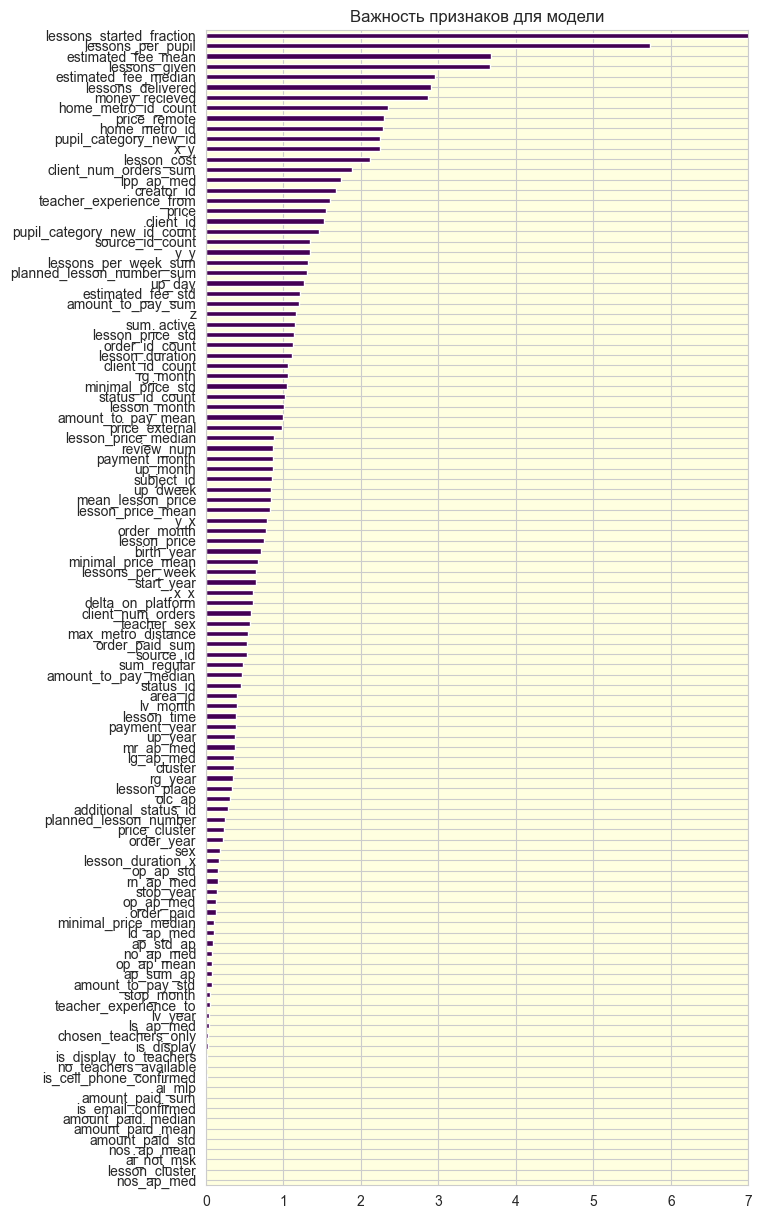

In [445]:
fig = pd.DataFrame(data={'score': cat_clf.feature_importances_}, 
                      index=X_train.columns).sort_values(by='score').plot(kind='barh', grid=True,
                        figsize=(7,15), legend=False, colormap='viridis', xlim=(0, 7),\
                          title='Важность признаков для модели')
fig.set(facecolor='lightyellow')
plt.show()

- на валидации достигнута метрика F1 практически 0.7, по отчету классификатора видим, что и полната и точность достигают достаточно высокого уровня
- по оценке важности признаков для модели заметно, что наиболее важными признаками для классификатора стали процент начала занятий, количество занятий на одного ученика
- далее проведу анализ шап-значений

In [446]:
explainer = shap.Explainer(cat_clf, X_train)
shap_values = explainer(X_train, check_additivity=False)

 99%|===================| 941/949 [00:31<00:00]        

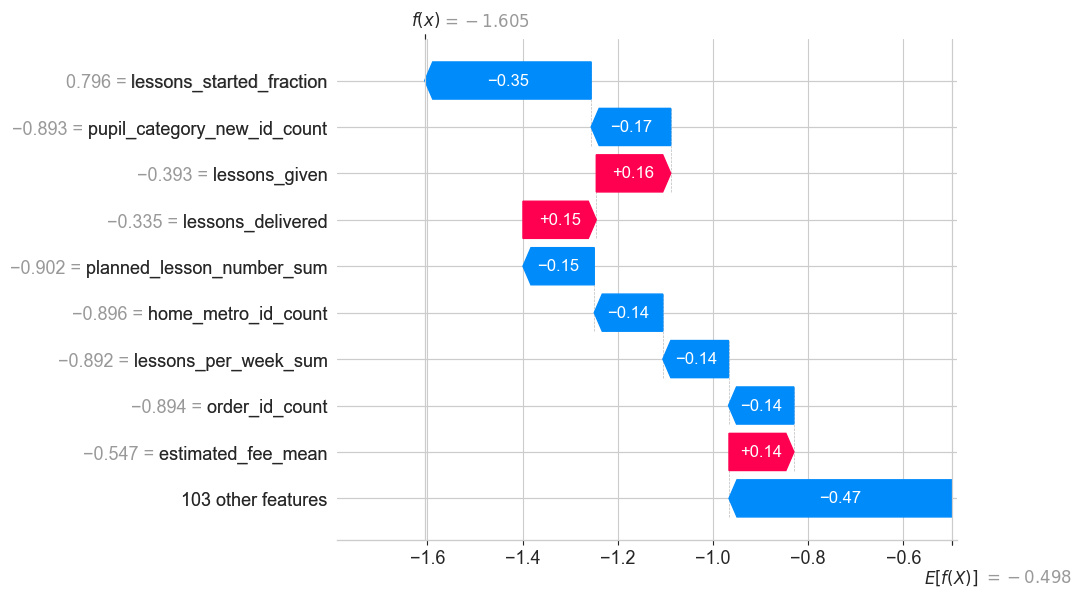

In [447]:
shap.plots.waterfall(shap_values[0])

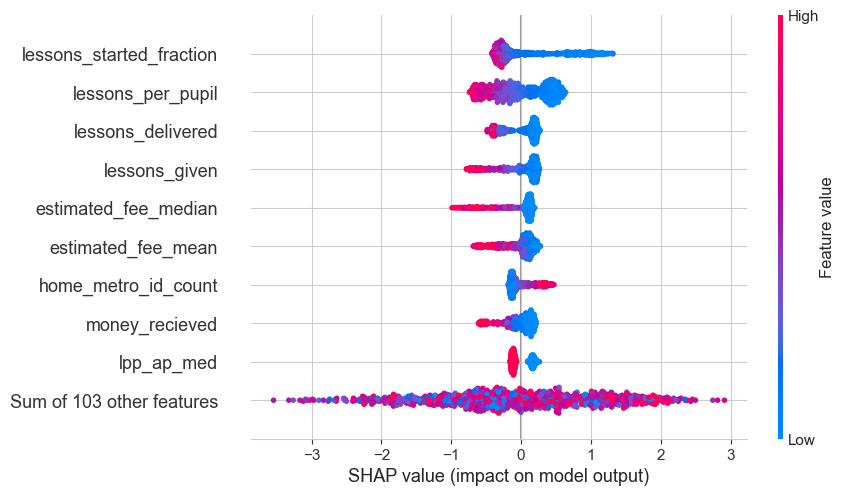

In [448]:
shap.plots.beeswarm(shap_values)

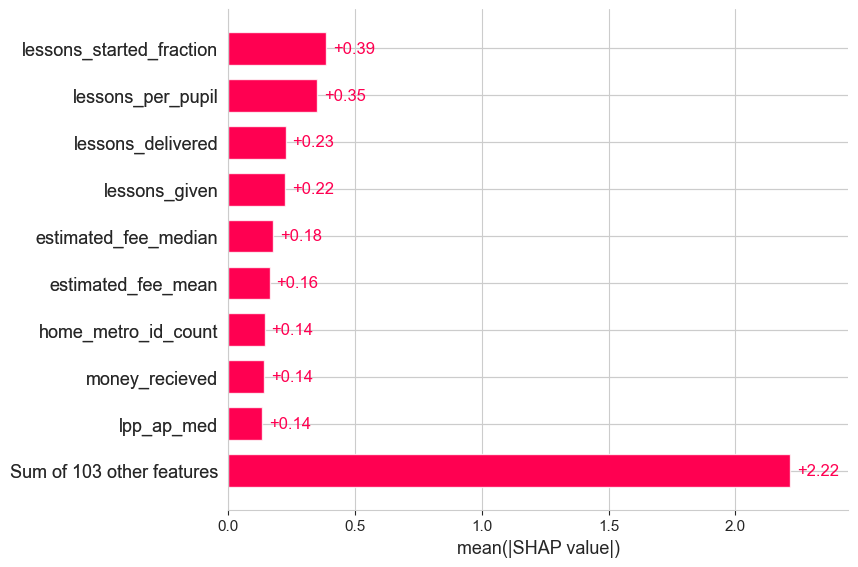

In [449]:
shap.plots.bar(shap_values)

- выводы по визуализации шап-значений:
- средние показатели шап-значений в принципе совпадают с оценкой важности признаков, проведенной выше: наиболее высокими коэффициентами обладают признаки - процент начала занятий, количество занятий на одного ученика, количество проведенных занятий
- по анализу графика beeswarm можно сделать следующие выводы:
  - чем выше доля начала занятий тем выше вероятность 0 класса, тоже самое касается и количества уроков на одного ученика и количества проведенных занятий
  - а вот относительно ориентировочной платы, ситуация противоположная чем выше ее значение, выше вероятность появления класса 1

***5. Тестирование модели:***

In [450]:
X_test = test.drop(['blocked', 'id', 'teacher_id', 'order_id', 'working_teacher_id'], axis=1)
y_test = test.blocked
X_test = X_test
X_test = scaler.transform(X_test)
f1_score(y_test, cat_clf.predict(X_test))

0.6697247706422018

***Общие выводы по проекту:***

- открыты датасеты:
  - со статистикой по репетиторам, содержащий целевую переменную blocked
  - с информацией о репетиторах, сразу удален столбец с 96% пропусков
  - ценами на занятия(в нем удалены полные дубликаты строк)
  - заявками, сразу удалены 4 столбца, содержащие около 90% пропусков
  - с информацией о занятиях (изменен тип данных нескольких столбцов на временной)
  - с информацией об учениках (изменен тип данных нескольких столбцов на временной)

- по результатам разведовочного анализа данных сделаны следующие выводы:
  - распределение средней цены урока у разных классов целевой переменной в принципе выглядит похоже, единственное - медиана у положительного класса(1) меньше и присутствие выбросов выше, но данные показатели не критичны
  - вот уже распределения общего количества полученных средств у положительного и отрицательного классов сильно разняться:
    - у отрицательного класса общее распределение гораздо сильнее смещено вправо, то есть среднее значение сильно превышает медианное по сравнению с положительным классом, то есть прподаватели, размеченные как "честные" в общем приносят больше средств и среди них есть явные лидеры, смещающие общее распределение, ниже попробую их найти и выделить
  - распределение общего количества проведенных уроков у положительного класса логично меньше чем у отрицательного и опять же несмотря на также имеещееся смещение вправо распределения положительного класса у отрицательного оно куда более выраженное, что опять же говорит о лидерах среди репетиторов
  - распределение доли начала занятий также отличается похожим образом, несмотря на довольно низкое значение медианного показателя (но у положительного класса он все-равно ниже), среди отрицательного класса есть преподаватель практически со стопроцентным результатом, тогда как у положительного класса макимум достигает 60%
  - количество занятий на одного ученика: у отрицательного класса среднее значение выше, чем у положительного, как и общее распределение несмотря на общую тенденцию правостороннего смещения
  - именно в октябре 2022 года количество зарегистрированных визитов на платформу резко увеличилось, после этого в 2023 году был такой же резкий спад
  - есть явные выбросы в датах рожения и начала прподавательской деятельности: поставлю соотвествующие пороги (с учетом существования платформы в течение 16 лет): для даты рождения поставлю интервал с 1918 года(возраст 90 на момент 2008 года) и до 2006 (возраст 18 лет), для даты начала преподавания 1936 (плюс 18 к минимальной дате рождения) и до максимальной даты в столбце
  - основная масса репетиторов родились во второй половнине 1980-х - 1990-х годах и начали преподавательскую деятельность в конце двухтысячных 2010-х годах
  - основная масса репетиторов не подтвердили электронный адрес и телефон
  - 2/3 репетиторов показаны в каталоге
  - 86% репетиторов разрешено назначать на заявки
  - распределение пола репетиторов:
    - в этом столбце 4 уникальных значения (известно, что 1 - мужской пол, 2 - женский, для двух других проставила одно значение - 0)
    - 73% репетиторов - женщины
  - 82% репетиторов не имеют ни одного отзыва, далее увеличение количества отзывов обратно пропорционально количеству репетиторов
  - в распределениях длительности и стоимости урока есть выбросы:
    - распределение длительности урока смещено вправо (среднее больше медианы), но не сильно (среднее - 61, медианное значение 60 минут)
    - распределение стоимости урока - аналогично (среднее - 532, медианное значение 500 рублей)
  - по тепловой карте становится понятно, что более всего таргет, кроме признаков из целевой таблицы, взаимосвязан с признаком "разрешено назначать на заявки"
  - есть планомерное увеличение количества "апдейтов" цены пропорционально времени (с некоторыми спадами) сразу достала из этого столбца численные признаки (год, месяц, день, час, день недели)
  - бОльшим спросом пользуются предметы с айди: 2, 8, 1
  - все "ценовые" признаки распределены в принципе аналогично: распределение смещено вправо (среднее превышает медианное значение: для цены у себя - среднее - 552/медианное - 400; для занятия на выезде - среднее - 746/медианное - 600; для онлайн-занятия - среднее - 673, медианное - 500)
  - по графику тренда дат занятий видно, что он явно присутствует - количество занятий распределяется по датам волнообразно (пики приходятся на октябрь-апрель, начало учебного года/подготовка к экзаменам, спады на январь/летние месяцы). В связи с этим извлеку из даты месяц в качестве численного признака
  - по бинарному столбцу "is_regular" видно, что только около 20% занятий автоматически возобновляются
  - по наиболее популярным фразам в текстовом столбце с пометками о домашнем задании видно, что никакой релевантной информации он не несет и к тому же содержит более 99% пропусков, удалила его
  - по распределению столбца со стоимость занятия видно, что распределение неравномерное, смещено вправо (среднее - 1184, медиана - 1000), также в столбце присуствуют выбросы
  - по распределению столбца с уже оплаченными занятиями ситуация аналогична: среднее - 1817, медиана - 1500, и также есть выбросы, интересно, что агрегатные показатели стоимостных признаков в данном столбце примерно на 40-50% превышают аналогичные показатели в таблице с ценами на занятия и в таблице с информацией по преподавателям
  - по распределению мест проведения занятий видно, что большинство(45%) занятий находятся в месте под меткой 4
  - 89% занятий имеют длительность в 1 час
  - цена урока для ученика распределена со смещением вправо (среднее - 1284, медиана - 1000), также в столбце присутствуют выбросы
  - только порядка 30% занятий имеют активный статус
  - обновленные даты занятий для учеников имеют такой же тренд как и даты в таблице с занятиями, поэтому не оставила этот коллинеарный признак в датасете
  - а вот столбец с информацией о приостановлении занятий до определенной даты имеет некоторые особенности: большинство дат в нем носит явно "вымышленный" характер как то 19 или 22 век, но так как информация в нем может носить полезный характер, из реально возможных дат я достану численные признаки с месяцем и годом, получившиеся пропуски заполнила нолями и таким образом создала два новых признака с месяцем и годом приостановки занятия
  - в информации по заявкам удалила строки, id которых равно 3211265, 3342337, 3605505, так как оно задублировано в других численных признаках, возможно было бы сохранить эти строки, но в них кроме этой информации, только "выбросы" и пропуски
  - столбец start_date практически дублирует столбец с датой оформления заявки, удален
  - пол репетитора: по данным заказчика значение 1 - мужской, 2-женский, 0 и 3 -"пол неизвестен", изменила этот столбец установив единое значение 0 для неизвестных значений
  - данные о минимальном/максимальном возрасте учителя содержат выбросы, возрастной диапазон ограничила интервалом от 16 до 90 лет, другие значения заполнила вторым по популярности ответом клиента
  - относительно столбца с комментариями, в нем в основном служебная информация от операторов колл-центра. Единственным важным элементном в этом столбце я нашла отсылки на оригинальный номер заявки, проверю, возможно он отсутствует в original_order_id, и тогда можно будет восстановить пропущенные значения:
    - таким образом удается восстановить порядка 60 тыс пропущенных значений в столбце original_order_id
  - столбец статус-айди обозначает статус оплаты заявки, из него я создам дополнительный признак order_paid, в котором к положительному классу (заявка оплачена) отнесу (по информации от заказчика) значения 5, 6, 13, 15; а к отрицательному все остальные значения
  - так как данные будут группироваться по колонке original_order_id, если в ней пропущенное значение значит заявка без дубля и сама является оригиналом,  все эти пропуски заполнила данными из столбца id заявки
  - так же создала новый столбец ***client_num_orders***, характеризующий количество заявок от одного клиента
- при формировании финального датасета я создала следующие признаки:
  - заявка оплачена, медианная сумма/средняя/отклонение суммы оплаты равно нулю
  - количество заявок больше/равно 6, медианная сумма оплаты равно нулю
  - среднее общей суммы заявок больше 140, медианная/средняя сумма оплаты равно нулю
  - получено более 15 тыс.руб., медианная сумма оплаты равно нулю
  - поставлено более 100 уроков, медианная сумма оплаты равно нулю
  - проведено более 150 уроков, медианная сумма оплаты равно нулю
  - доля начала занятий равна или более 0.4, медианная сумма оплаты равно нулю
  - более 6 уроков на одного ученика, медианная сумма оплаты равно нулю
  - место проведения занятий Москва, средняя цена занятия менее или равна 700 руб.
  - место проведения занятий не Москва, средняя цена занятия менее или равна 300 руб.
  - количество отзывов более/равно 11, медианная сумма оплаты равно нулю
  - общая сумма к оплате более/равна 5500, медианная сумма оплаты равно нулю
  - отклонение суммы к оплате более/равно 10, медианная сумма оплаты равно нулю
  - количество заявок более/равно 57, медианная сумма оплаты равно нулю
- на валидации достигнута метрика F1 практически 0.7, по отчету классификатора (CatBoostClassifier) видно, что и полнота и точность достигают достаточно высокого уровня
- по оценке важности признаков для модели заметно, что наиболее важными признаками для классификатора стали процент начала занятий, количество занятий на одного ученика
- средние показатели шап-значений в принципе совпадают с оценкой важности признаков, проведенной выше: наиболее высокими коэффициентами обладают признаки - процент начала занятий, количество занятий на одного ученика, количество проведенных занятий
- по анализу графика beeswarm можно сделать следующие выводы:
  - чем выше доля начала занятий тем выше вероятность 0 класса, тоже самое касается и количества уроков на одного ученика и количества проведенных занятий
  - а вот относительно ориентировочной платы, ситуация противоположная чем выше ее значение, выше вероятность появления класса 1 
- на тестировании целевая метрика достигла 0.67
  